In [61]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL

In [50]:
print(torch.__version__)

2.1.1


In [51]:
# GPU device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_cached())

cuda:0
NVIDIA GeForce RTX 3090
1
0
0
0


/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


# ImageNet dataset preprocessing

* The image is resized with its shorter side randomly sampled in [256, 480] for scale augmentation. 
* A 224×224 crop is randomly sampled from an image or its horizontal flip, 
* with the per-pixel mean subtracted.


## random crop 224
## random horizontal flip
## per-pixel mean substracted

In [52]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # rand crop
        transforms.RandomHorizontalFlip(), # horizontal flip
        transforms.ToTensor() # tensor로 변환
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # 256으로 resize
        transforms.CenterCrop(224), # 224로 crop
        transforms.ToTensor() # tensor로 변환
    ]),
}

In [53]:
num_classes = 1000
# Load the ImageNet class index mapping
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

1281167
50000
torch.Size([3, 224, 224])


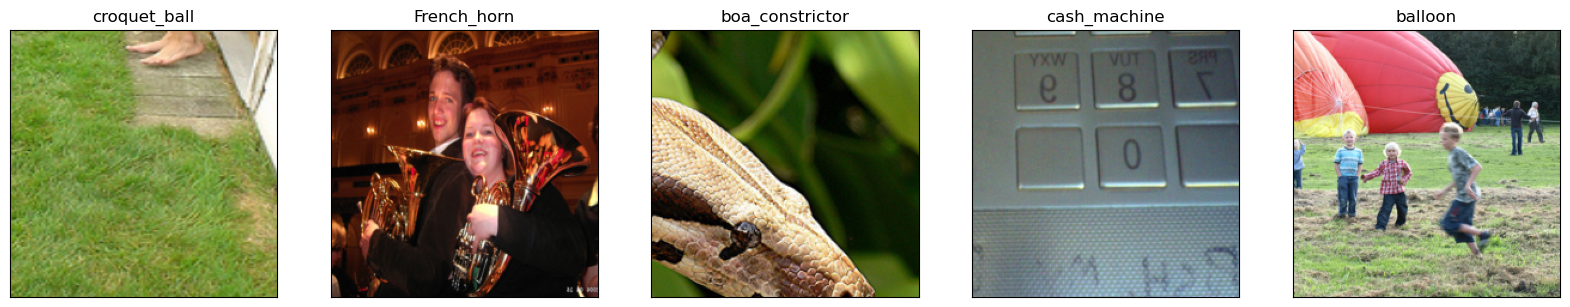

In [66]:
data_dir = '/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet'

# /home/hslee/Desktop/Datasets ILSVRC2012_ImageNet/train
train_dir = os.path.join(data_dir, 'train')
trainset = datasets.ImageFolder(train_dir, data_transforms['train'])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

# /home/hslee/Desktop/Datasets ILSVRC2012_ImageNet/val
val_dir = os.path.join(data_dir, 'val')
valset = datasets.ImageFolder(val_dir, data_transforms['val'])
val_loader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=True, num_workers=4)

# Download ImageNet labels
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# data shape
print(len(trainset))
print(len(valset))
print(trainset[0][0].shape)

writer = SummaryWriter('runs/resnet34_imagenet_experiment_1')
# plot 5 sample randomimages
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    # record the sample images to tensorboard
    writer.add_image('4_sample_images', image, i)
    writer.flush() 
    
    
    

In [67]:
torch.cuda.empty_cache()


In [68]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = models.resnet34(pretrained=False, progress=True)
print(model.eval)
model = model.to(device)

# hyper parameters
## learning rate
lr = 0.01
## momentum
momentum = 0.9
## weight decay
L2 = 0.0001
# iterations
iterations = (len(trainset) // 256) + 1
print(f"1peoch : {iterations} iterations")
# epochs
epochs = (60 * (10**4)) // iterations + 1
print(f"epoch : {epochs} epochs")

## optimizer
## scheduler
## loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [69]:
# record model to tensorboard
# Assuming 'device' is defined as torch.device("cuda") or "cuda:0"
input_tensor = trainset[0][0].unsqueeze(0).to(device)
writer.add_graph(model, input_tensor)


In [73]:
import time
# Start measuring time
start_time = time.time()

# ------------------------------------------------------------------------------------------------------------------------------

# training no pretrained resnet34 model with GPU
model.train().to(device)
for epoch in range(epochs):
    running_loss = 0.0
    print(f"{epoch} / {epochs} epoch --------------------------------------------")
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # every 1,0000 iteration
        # training loss
        running_loss += loss.item()
        if i % 500 == 499:
            print(f"[{epoch}, {i}] loss : {running_loss / 500}")
            running_loss = 0.0
            writer.add_scalar('training loss', loss.item(), epoch * len(train_loader) + i)
            writer.flush()
    # every epoch
    # validation loss
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"validation accuracy : {100 * correct / total}")
    writer.add_scalar('validation accuracy', 100 * correct / total, epoch)
    writer.flush()
        
# ------------------------------------------------------------------------------------------------------------------------------        
        
# End measuring time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")        

0 / 120 epoch --------------------------------------------
[0, 499] loss : 6.139452184677124
[0, 999] loss : 5.895896644592285
[0, 1499] loss : 5.689026235580444
